Using device: cuda

Running experiments with layer width: 64
Trainable layers: 1, Random layers: 1
Avg final training loss (last 20 steps): 1.9113
Trainable layers: 1, Random layers: 2
Avg final training loss (last 20 steps): 433.7770
Trainable layers: 1, Random layers: 3
Avg final training loss (last 20 steps): 123057296.1492
Trainable layers: 2, Random layers: 1
Avg final training loss (last 20 steps): 2.1714
Trainable layers: 2, Random layers: 2
Avg final training loss (last 20 steps): 6.5140
Trainable layers: 2, Random layers: 3
Avg final training loss (last 20 steps): 48372202607185896.0000
Trainable layers: 3, Random layers: 1
Avg final training loss (last 20 steps): 2.3366
Trainable layers: 3, Random layers: 2
Avg final training loss (last 20 steps): 5.4043
Trainable layers: 3, Random layers: 3
Avg final training loss (last 20 steps): 11335584256414768.0000

Running experiments with layer width: 128
Trainable layers: 1, Random layers: 1
Avg final training loss (last 20 steps): 2

<Figure size 1800x800 with 0 Axes>

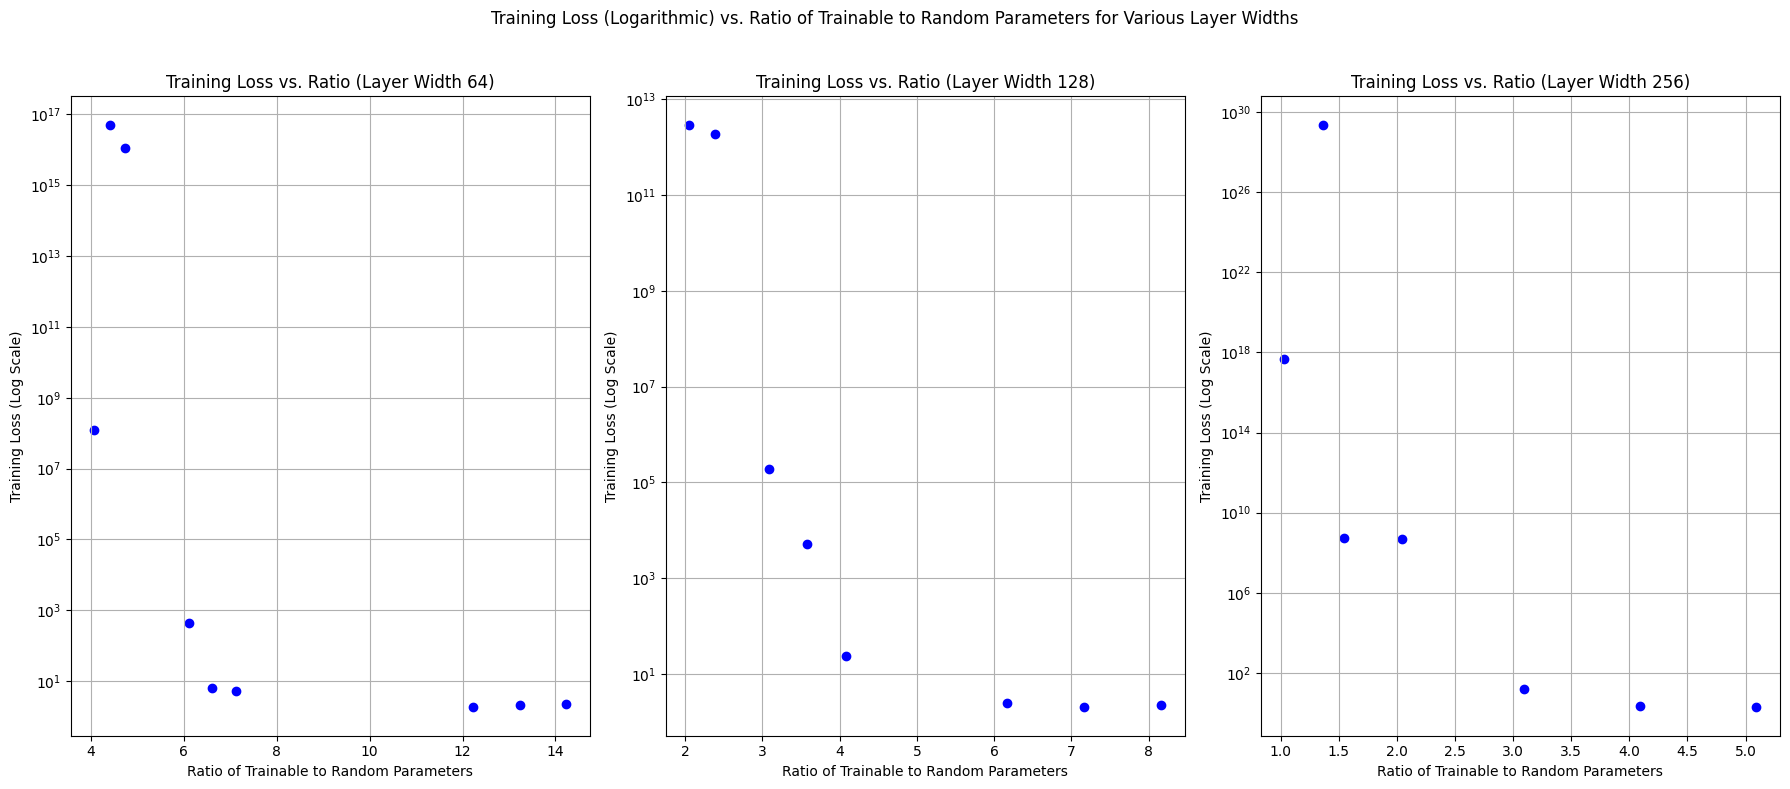

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Configuration Parameters
batch_size = 64
learning_rate = 0.01
num_epochs = 5  # Number of epochs for training
dataset_name = 'MNIST'
subset_size = 100  # Using only 100 examples for quick testing

# Hyperparameters for Experiment
trainable_layer_counts = [1, 2, 3]  # Number of trainable layers to test
random_layer_counts = [1, 2, 3]     # Number of frozen random layers to test
layer_widths = [64, 128, 256]       # Width of each layer (number of neurons)

# Function to load the dataset with a small subset
def load_dataset(name='MNIST', subset_size=100):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    if name == 'MNIST':
        train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    else:
        raise ValueError("Unsupported dataset")
    
    # Create a subset with only subset_size examples
    indices = np.random.choice(len(train_dataset), size=subset_size, replace=False)
    subset = torch.utils.data.Subset(train_dataset, indices)
    train_loader = torch.utils.data.DataLoader(subset, batch_size=batch_size, shuffle=True)
    return train_loader

# Function to create the model dynamically
class DynamicNet(nn.Module):
    def __init__(self, input_size, output_size, trainable_layers, random_layers, layer_width):
        super(DynamicNet, self).__init__()
        layers = []
        # Add trainable layers
        for _ in range(trainable_layers):
            layers.append(nn.Linear(input_size, layer_width))
            layers.append(nn.ReLU())
            input_size = layer_width
        # Add frozen random layers
        for _ in range(random_layers):
            rand_layer = nn.Linear(input_size, layer_width)
            # Initialize with random weights and biases
            nn.init.normal_(rand_layer.weight)
            nn.init.normal_(rand_layer.bias)
            rand_layer.weight.requires_grad = False
            rand_layer.bias.requires_grad = False
            layers.append(rand_layer)
            layers.append(nn.ReLU())
            input_size = layer_width
        # Final output layer
        layers.append(nn.Linear(input_size, output_size))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# Function to count parameters
def count_parameters(model):
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    return trainable_params, frozen_params

# Load dataset with the specified subset size
train_loader = load_dataset(dataset_name, subset_size=subset_size)

# Main Experiment Loop
results = {}  # To store results for plotting

for layer_width in layer_widths:
    results[layer_width] = {'ratios': [], 'losses': []}
    print(f"\nRunning experiments with layer width: {layer_width}")
    for train_layers in trainable_layer_counts:
        for rand_layers in random_layer_counts:
            print(f"Trainable layers: {train_layers}, Random layers: {rand_layers}")
            # Create the model
            input_size = 28 * 28
            output_size = 10
            model = DynamicNet(input_size, output_size, train_layers, rand_layers, layer_width).to(device)
            # Count parameters
            trainable_params, frozen_params = count_parameters(model)
            ratio = trainable_params / (frozen_params + 1e-8)  # Add epsilon to avoid division by zero
            # Loss function and optimizer
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
            # Training loop
            model.train()
            losses = []
            for epoch in range(num_epochs):
                total_loss = 0
                for inputs, targets in train_loader:
                    inputs = inputs.view(-1, 28 * 28).to(device)
                    targets = targets.to(device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item() * inputs.size(0)
                    losses.append(loss.item())
                avg_loss = total_loss / len(train_loader.dataset)
            # Calculate average of the last 20 training losses
            avg_final_loss = np.mean(losses[-20:]) if len(losses) >= 20 else np.mean(losses)
            print(f"Avg final training loss (last 20 steps): {avg_final_loss:.4f}")
            # Store results
            results[layer_width]['ratios'].append(ratio)
            results[layer_width]['losses'].append(avg_final_loss)

# Updated Visualization with Logarithmic Training Loss Axis and Correctly Connected Lines
plt.figure(figsize=(18, 8))

# Updated Visualization with Logarithmic Training Loss Axis (Scatter Plot Only)
plt.figure(figsize=(18, 8))

# Sort data and plot for each layer width
for idx, layer_width in enumerate(layer_widths):
    plt.subplot(1, len(layer_widths), idx + 1)  # Create separate subplot for each layer width
    # Extract and sort data based on ratios
    ratios = np.array(results[layer_width]['ratios'])
    losses = np.array(results[layer_width]['losses'])
    sorted_indices = np.argsort(ratios)  # Sort by ratio
    ratios_sorted = ratios[sorted_indices]
    losses_sorted = losses[sorted_indices]
    
    # Plot with scatter only
    plt.scatter(ratios_sorted, losses_sorted, label=f'Layer Width {layer_width}', color='blue')
    
    plt.xlabel('Ratio of Trainable to Random Parameters')
    plt.ylabel('Training Loss (Log Scale)')
    plt.yscale('log')  # Logarithmic scale for loss
    plt.title(f'Training Loss vs. Ratio (Layer Width {layer_width})')
    plt.grid(True)

# Overall layout and legend
plt.suptitle('Training Loss (Logarithmic) vs. Ratio of Trainable to Random Parameters for Various Layer Widths')
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to include the title
plt.show()



Using device: cuda

Running experiments with layer width: 64
Trainable layers: 1, Random layers: 1
Avg final training loss (last 20 steps): 2.2000
Trainable layers: 1, Random layers: 2
Avg final training loss (last 20 steps): 5.7348
Trainable layers: 1, Random layers: 3
Avg final training loss (last 20 steps): 1188545717.3289
Trainable layers: 2, Random layers: 1
Avg final training loss (last 20 steps): 2.2147
Trainable layers: 2, Random layers: 2
Avg final training loss (last 20 steps): 2.3482
Trainable layers: 2, Random layers: 3
Avg final training loss (last 20 steps): nan
Trainable layers: 3, Random layers: 1
Avg final training loss (last 20 steps): 2.3088
Trainable layers: 3, Random layers: 2
Avg final training loss (last 20 steps): 2.2652
Trainable layers: 3, Random layers: 3
Avg final training loss (last 20 steps): 2.8713

Running experiments with layer width: 128
Trainable layers: 1, Random layers: 1
Avg final training loss (last 20 steps): 1.9996
Trainable layers: 1, Random la

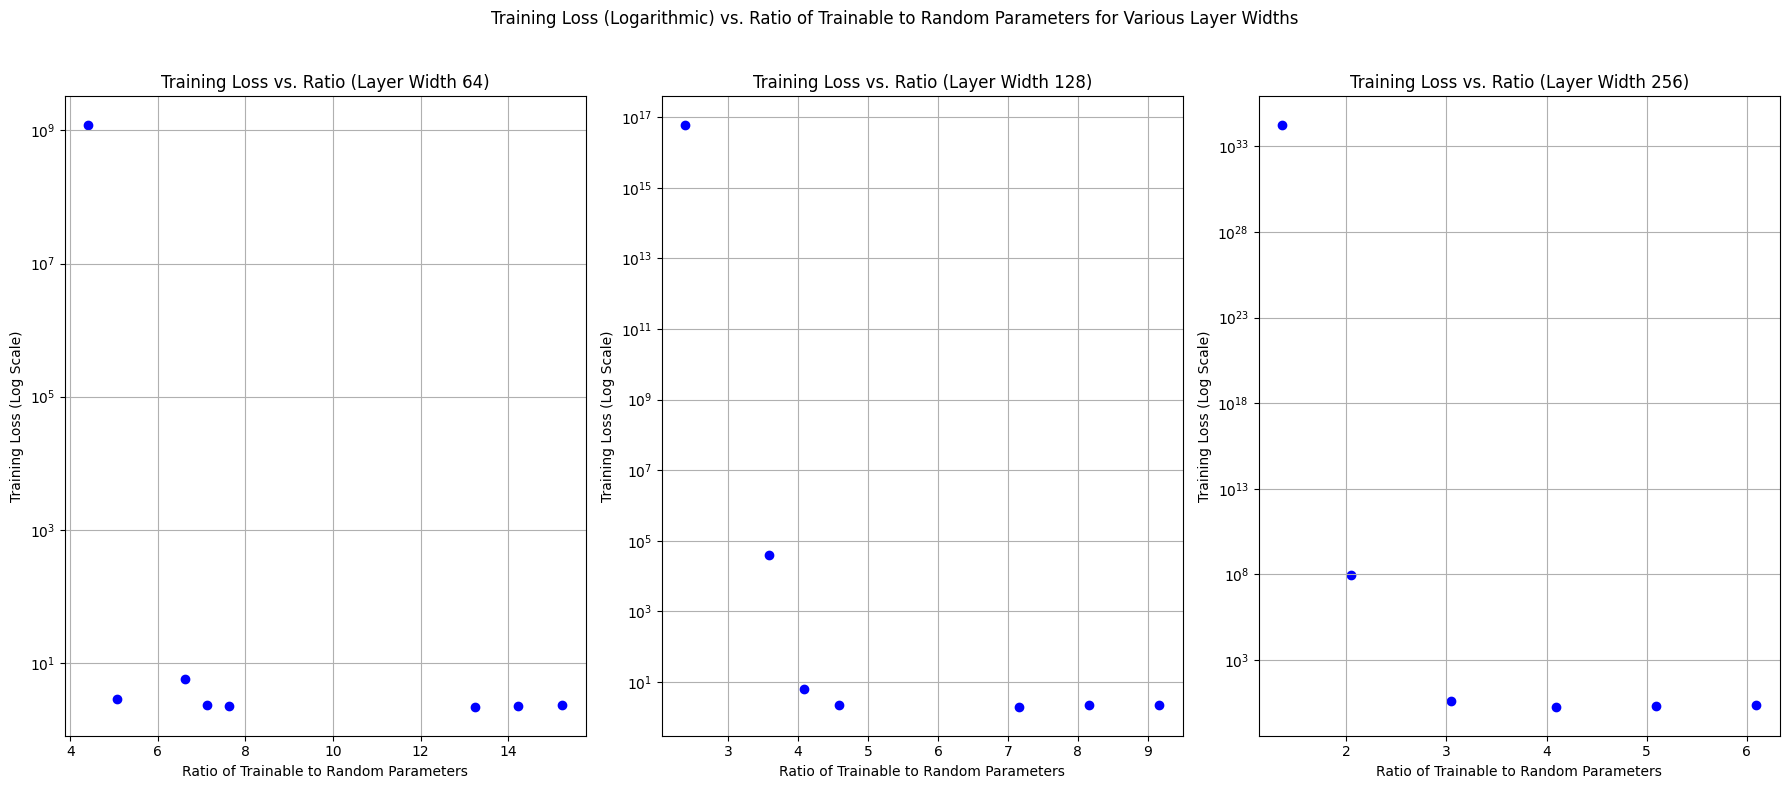

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Configuration Parameters
batch_size = 64
learning_rate = 0.01
num_epochs = 5  # Number of epochs for training
dataset_name = 'MNIST'
subset_size = 100  # Using only 100 examples for quick testing

# Hyperparameters for Experiment
trainable_layer_counts = [1, 2, 3]  # Number of trainable layers to test
random_layer_counts = [1, 2, 3]     # Number of frozen random layers to test
layer_widths = [64, 128, 256]       # Width of each layer (number of neurons)

# Function to load the dataset with a small subset
def load_dataset(name='MNIST', subset_size=100):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    if name == 'MNIST':
        train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    else:
        raise ValueError("Unsupported dataset")
    
    # Create a subset with only subset_size examples
    indices = np.random.choice(len(train_dataset), size=subset_size, replace=False)
    subset = torch.utils.data.Subset(train_dataset, indices)
    train_loader = torch.utils.data.DataLoader(subset, batch_size=batch_size, shuffle=True)
    return train_loader

# Function to create the model dynamically with the new structure
class DynamicNet(nn.Module):
    def __init__(self, input_size, output_size, trainable_layers, random_layers, layer_width):
        super(DynamicNet, self).__init__()
        layers = []
        # Add initial input layer
        layers.append(nn.Linear(input_size, layer_width))
        layers.append(nn.ReLU())
        input_size = layer_width
        # Add random frozen layers
        for _ in range(random_layers):
            rand_layer = nn.Linear(input_size, layer_width)
            # Initialize with random weights and biases
            nn.init.normal_(rand_layer.weight)
            nn.init.normal_(rand_layer.bias)
            rand_layer.weight.requires_grad = False
            rand_layer.bias.requires_grad = False
            layers.append(rand_layer)
            layers.append(nn.ReLU())
            input_size = layer_width
        # Add trainable layers
        for _ in range(trainable_layers):
            layers.append(nn.Linear(input_size, layer_width))
            layers.append(nn.ReLU())
            input_size = layer_width
        # Final output layer
        layers.append(nn.Linear(input_size, output_size))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# Function to count parameters
def count_parameters(model):
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    return trainable_params, frozen_params

# Load dataset with the specified subset size
train_loader = load_dataset(dataset_name, subset_size=subset_size)

# Main Experiment Loop
results = {}  # To store results for plotting

for layer_width in layer_widths:
    results[layer_width] = {'ratios': [], 'losses': []}
    print(f"\nRunning experiments with layer width: {layer_width}")
    for train_layers in trainable_layer_counts:
        for rand_layers in random_layer_counts:
            print(f"Trainable layers: {train_layers}, Random layers: {rand_layers}")
            # Create the model
            input_size = 28 * 28
            output_size = 10
            model = DynamicNet(input_size, output_size, train_layers, rand_layers, layer_width).to(device)
            # Count parameters
            trainable_params, frozen_params = count_parameters(model)
            ratio = trainable_params / (frozen_params + 1e-8)  # Add epsilon to avoid division by zero
            # Loss function and optimizer
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
            # Training loop
            model.train()
            losses = []
            for epoch in range(num_epochs):
                total_loss = 0
                for inputs, targets in train_loader:
                    inputs = inputs.view(-1, 28 * 28).to(device)
                    targets = targets.to(device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item() * inputs.size(0)
                    losses.append(loss.item())
                avg_loss = total_loss / len(train_loader.dataset)
            # Calculate average of the last 20 training losses
            avg_final_loss = np.mean(losses[-20:]) if len(losses) >= 20 else np.mean(losses)
            print(f"Avg final training loss (last 20 steps): {avg_final_loss:.4f}")
            # Store results
            results[layer_width]['ratios'].append(ratio)
            results[layer_width]['losses'].append(avg_final_loss)

# Updated Visualization with Logarithmic Training Loss Axis and Correctly Connected Lines
plt.figure(figsize=(18, 8))

# Sort data and plot for each layer width
for idx, layer_width in enumerate(layer_widths):
    plt.subplot(1, len(layer_widths), idx + 1)  # Create separate subplot for each layer width
    # Extract and sort data based on ratios
    ratios = np.array(results[layer_width]['ratios'])
    losses = np.array(results[layer_width]['losses'])
    sorted_indices = np.argsort(ratios)  # Sort by ratio
    ratios_sorted = ratios[sorted_indices]
    losses_sorted = losses[sorted_indices]
    
    # Plot with scatter only
    plt.scatter(ratios_sorted, losses_sorted, label=f'Layer Width {layer_width}', color='blue')
    
    plt.xlabel('Ratio of Trainable to Random Parameters')
    plt.ylabel('Training Loss (Log Scale)')
    plt.yscale('log')  # Logarithmic scale for loss
    plt.title(f'Training Loss vs. Ratio (Layer Width {layer_width})')
    plt.grid(True)

# Overall layout and legend
plt.suptitle('Training Loss (Logarithmic) vs. Ratio of Trainable to Random Parameters for Various Layer Widths')
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to include the title
plt.show()
